## Transient Data Analysis

In [145]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import emcee 
import time
import corner

In [146]:
data = np.load(r"C:\Users\ricca\Documents\Unimib-Code\AstroStatistics\AML\Notebooks\AstroStatistics\Data\transient.npy")

In [147]:
Time = data.T[0]
vals = data.T[1]
errs = data.T[2]

In [148]:
# Define the likelihood function (PDF)
def pdf(x):
    """
    Probability density function for the transient data.
    
    Parameters
    ----------
    Time : array-like
        The time values.
    A : float
        The amplitude of the transient.
    b : float
        The constant offset of the transient.
    alpha : float
        The decay constant.
    x0 : float
        The time at which decay starts.
    
    Returns
    -------
    array-like
        The PDF evaluated at each time point.
    """
    output = np.where(Time > x[3], x[1] + x[0] * np.exp(-x[2] * (Time - x[3])), x[1])
    return output

def func(Time,A,b,alpha,t0):
    output = np.where(Time > t0, b + A * np.exp(-alpha * (Time -t0)),b)
    return output

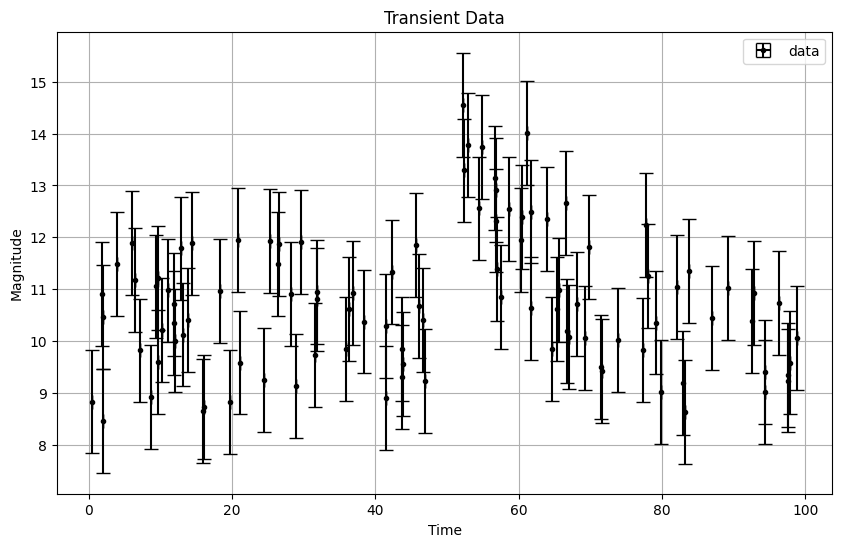

In [149]:
plt.figure(figsize=(10, 6))
plt.errorbar(Time, vals, xerr=0, yerr=errs,capsize=5, fmt=".", label="data", color='black')
plt.grid()
plt.xlabel('Time')
plt.ylabel('Magnitude')
plt.title('Transient Data')
plt.legend()

Guess parameters estimates:
1. b = $ \frac{1}{30} \sum_{i=1}^{30} y_i$
2. A = $\max\{y\}$ - b
3. $\alpha = t$ | $ y(\alpha) = \frac{\max\{y\}}{e}$
4. $t_0 = t$ | $y(t) = \max\{y\} $ 

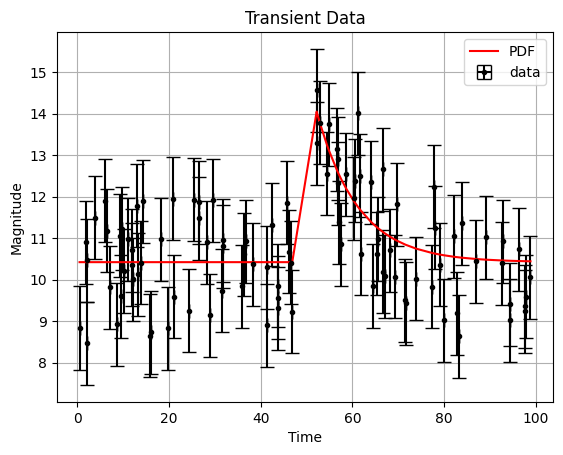

In [150]:
plt.errorbar(Time, vals, xerr=0, yerr=errs,capsize=5, fmt=".", label="data", color='black')
plt.plot(Time,func(Time,*np.array([max(vals)-vals[:20].mean(),vals[:20].mean(),1/9,np.argmax(vals)])), color='red', label="PDF")
plt.grid()
plt.xlabel('Time')
plt.ylabel('Magnitude')
plt.title('Transient Data')
plt.legend()

In [151]:
from scipy import stats
import numpy as np

def prior(x):
    """
    Log prior for parameters [A, b, alpha, x0].
    Uniform priors:
    - A, b: between 0 and 50
    - alpha: between 0 and 100
    - x0: between exp(-5) and exp(5), uniform in log space
    """
    A, b, alpha, x0 = x

    if not (0 <= A <= 50 and 0 <= b <= 50 and 0 <= alpha <= 100 and np.exp(-5) <= x0 <= np.exp(5)):
        return -np.inf  # outside the prior bounds

    log_prior_A     = np.log(1.0 / 50)   # uniform(0, 50)
    log_prior_b     = np.log(1.0 / 50)
    log_prior_alpha = np.log(1.0 / 100)
    log_prior_x0    = np.log(1.0 / (np.exp(5) - np.exp(-5)))

    return log_prior_A + log_prior_b + log_prior_alpha + log_prior_x0

def log_likelihood(x):
    """
    Gaussian log-likelihood for the transient signal model. \
    If data follow the model +/- stocastic errors, the likelihood will follow the chi-squared distribution, with N-V degrees of freedom.
    Parameters
    ----------
    
    x : array-like
        The parameters [A, b, alpha, x0].
        
    Returns
    -------
    float
        The log-likelihood value.
    """
    y_model = pdf(x)  # or func(Time, *x)

    if np.any(np.isnan(y_model)) or np.any(~np.isfinite(y_model)):
        return -np.inf

    return -0.5 * np.sum(((vals - y_model) / errs)**2)


def posterior(x):
    """
    Log posterior function combining prior and likelihood.
    """
    
    log_prior_value = prior(x)
    if not np.isfinite(log_prior_value):
        return -np.inf

    log_like = log_likelihood(x)
    if not np.isfinite(log_like):
        return -np.inf

    return log_like + log_prior_value



In [152]:
ndim     = 4  # number of parameters in the model
nwalkers = 10  # number of MCMC walkers
nsteps   = int(1e5)  # number of MCMC steps to take **for each walker**

In [153]:
guess_parameters = np.array([max(vals)/2,vals[:20].mean(),0.2,50]) + np.random.randn(nwalkers, ndim) * 1e-6

In [154]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, posterior)
elapsed=time.time()
print("Starting MCMC...")
sampler.run_mcmc(guess_parameters, nsteps)
print("MCMC finished in %s seconds" % (time.time() - elapsed))

Starting MCMC...
MCMC finished in 134.50700640678406 seconds


In [155]:
tau = sampler.get_autocorr_time()

In [156]:
print(tau)

[90.20915237 68.17979993 80.04527972 89.74372709]


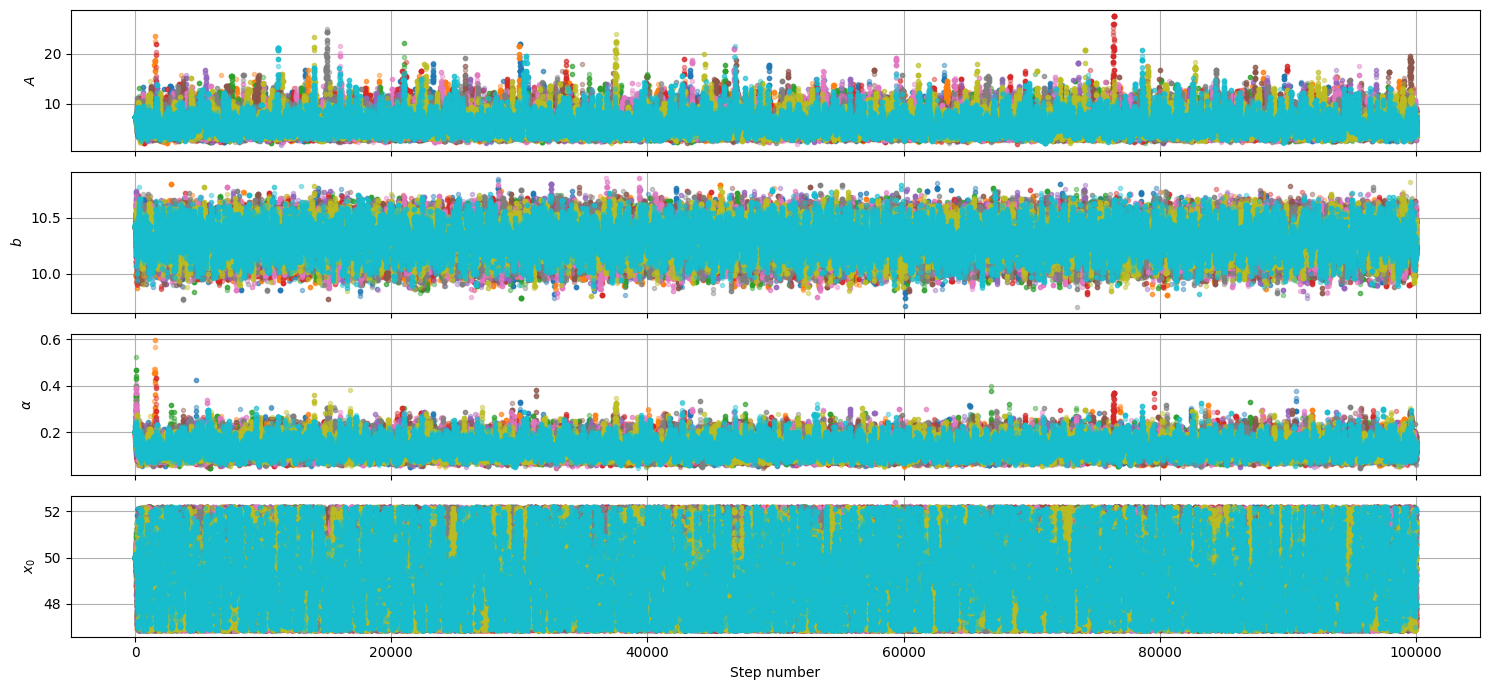

In [157]:
labels = [r"$A$", r"$b$", r"$\alpha$", r"$x_{0}$"]
fig, axes = plt.subplots(ndim, figsize=(15, 7), sharex=True)

for i in range(ndim):
    ax = axes[i]
    ax.plot(sampler.get_chain()[:,:,i], '.',alpha=0.4)
    ax.set_ylabel(labels[i])
    ax.grid(True)
axes[-1].set_xlabel("Step number")
plt.tight_layout()


In [236]:
burn_idx = 1000

Burn first burn_idx points

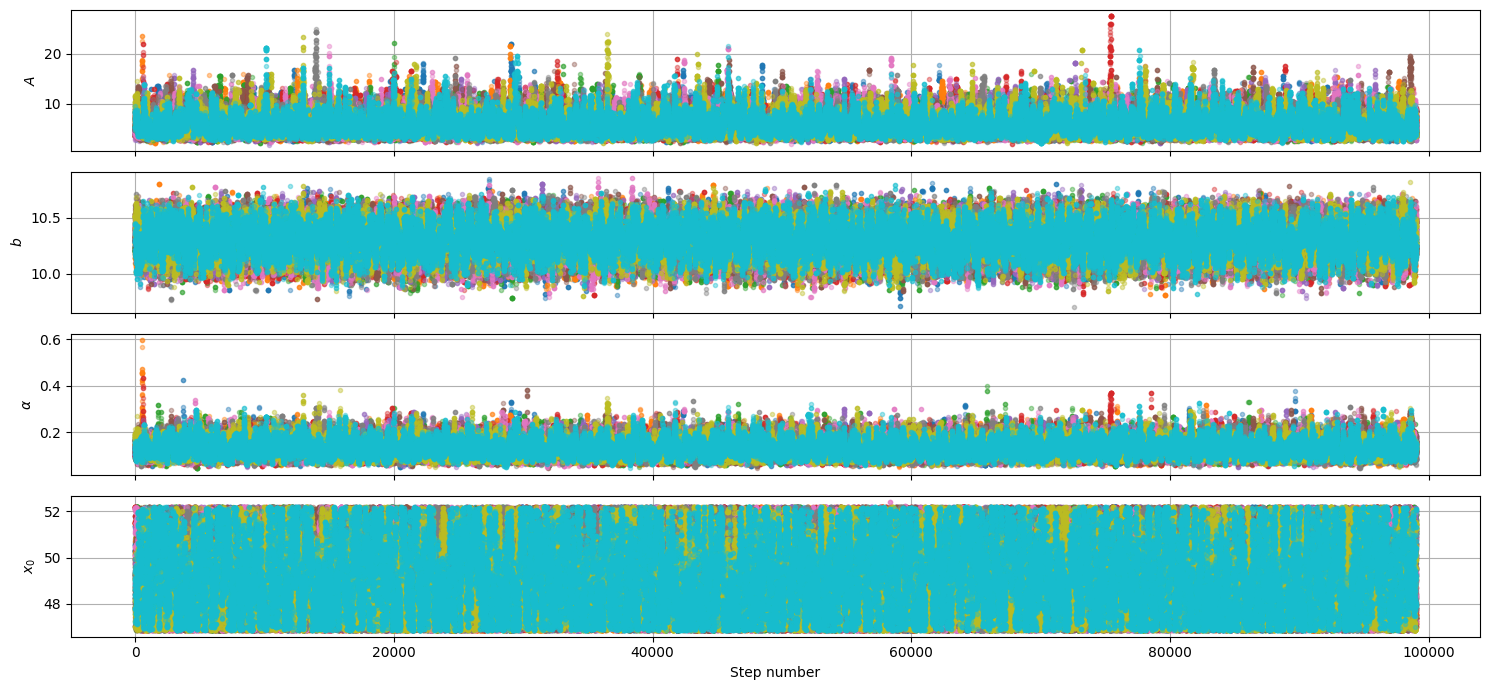

In [237]:
labels = [r"$A$", r"$b$", r"$\alpha$", r"$x_{0}$"]
fig, axes = plt.subplots(ndim, figsize=(15, 7), sharex=True)

for i in range(ndim):
    ax = axes[i]
    ax.plot(sampler.get_chain()[burn_idx:, :, i], '.',alpha=0.4)
    ax.set_ylabel(labels[i])
    ax.grid(True)
axes[-1].set_xlabel("Step number")
plt.tight_layout()


In [238]:
samples = sampler.get_chain(flat=False, discard=burn_idx, thin=int(max(tau)))
flat_samples = sampler.get_chain(flat=True, discard=burn_idx, thin=int(max(tau)))

In [239]:
quantiles = np.array([16, 50, 95])

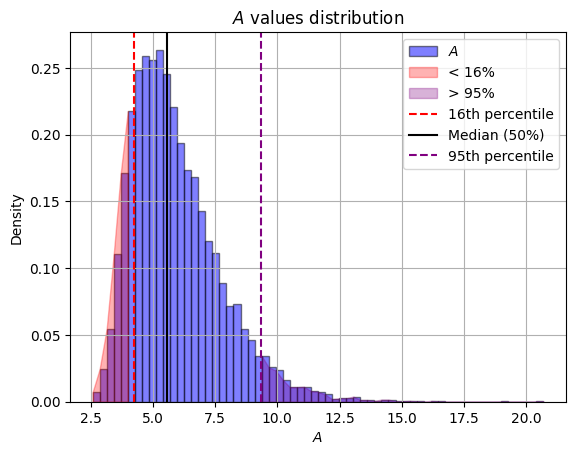

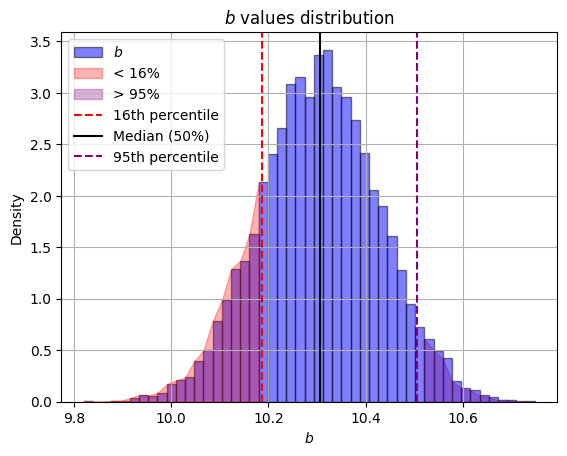

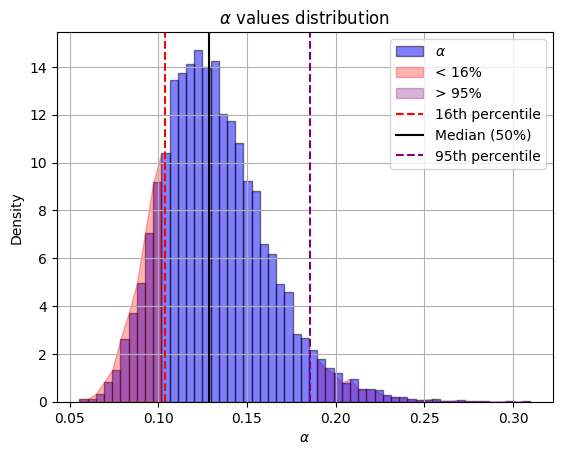

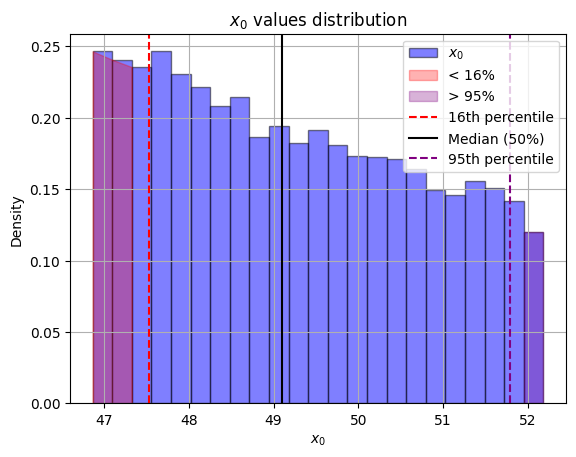

In [240]:
for i in range(4):
    q16, q50, q95 = np.percentile(flat_samples[:, i], quantiles)
    
    counts, bins, _ = plt.hist(flat_samples.T[i], bins='scott', density=True, histtype='barstacked', label=labels[i], alpha=0.5, color='blue', edgecolor='black')
    
    # Fill <16%
    mask_low = bins <= q16
    plt.fill_between(bins[mask_low], 0, np.interp(bins[mask_low], bins[:-1], counts), color='red', alpha=0.3, label='< 16%')

    # Fill >95%
    mask_high = bins >= q95
    plt.fill_between(bins[mask_high], 0, np.interp(bins[mask_high], bins[:-1], counts), color='purple', alpha=0.3, label='> 95%')

    # Vertical lines
    plt.axvline(q16, color='red', linestyle='--', label='16th percentile')
    plt.axvline(q50, color='black', linestyle='-', label='Median (50%)')
    plt.axvline(q95, color='purple', linestyle='--', label='95th percentile')
    
    
    plt.ylabel('Density')
    plt.xlabel(labels[i])
    plt.legend()
    plt.grid()
    plt.title(labels[i]+" values distribution")
    plt.show()

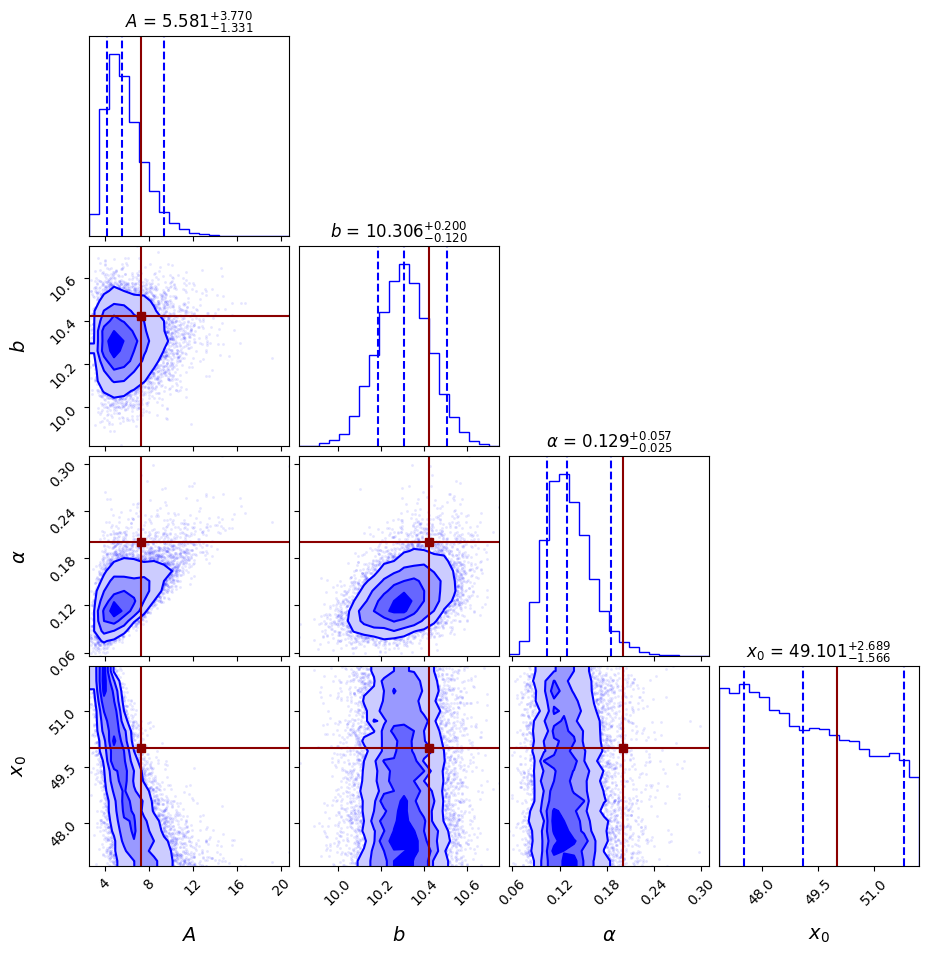

In [248]:
# Define true values (make sure vals is defined appropriately)
true_values = np.array([
    max(vals) / 2,
    np.mean(vals[:20]),
    0.2,
    50
])

# Generate corner plot
fig = corner.corner(
    flat_samples,
    labels=labels,  # customize these labels as needed
    truths=true_values,
    quantiles=quantiles*0.01,
    show_titles=True,
    title_fmt=".3f",              # Number format in titles
    title_kwargs={"fontsize": 12},
    label_kwargs={"fontsize": 14},
    truth_color="darkred",
    color="blue",
    fill_contours=True
)

In [242]:
mcmc_estimates = np.percentile(flat_samples, q=quantiles, axis=0)

for i, label in enumerate(labels):
    median = mcmc_estimates[1, i]
    minus = median - mcmc_estimates[0, i]
    plus = mcmc_estimates[2, i] - median

In [243]:
x_vals = np.random.uniform(0, samples.shape[0], 100).astype(int)
walker = np.random.randint(0, samples.shape[1], 1).astype(int)
p0 = samples[x_vals,walker,0]
p1 = samples[x_vals,walker,1]
p2 = samples[x_vals,walker,2]
p3 = samples[x_vals,walker,3]

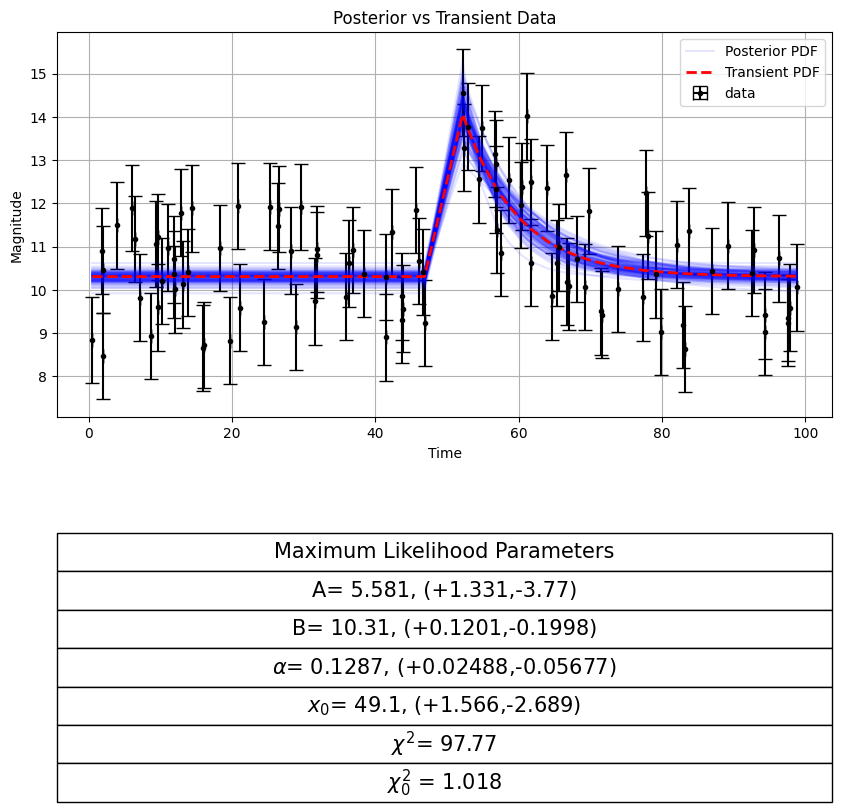

In [251]:
plt.figure(figsize=(10, 5))
plt.errorbar(Time, vals, xerr=0, yerr=errs,capsize=5, fmt=".", label="data", color='black')
for k in range(99):
    plt.plot(Time,func(Time,*np.array([p0[k],p1[k],p2[k],p3[k]])), color='blue', alpha=0.1)
plt.plot(Time,func(Time,*np.array([p0[99],p1[99],p2[99],p3[99]])), color='blue', alpha=0.1, label="Posterior PDF")
plt.plot(Time,func(Time,*np.array([mcmc_estimates[1, 0],mcmc_estimates[1, 1],mcmc_estimates[1, 2],mcmc_estimates[1, 3]])), linestyle="--",color='red', label="Transient PDF", linewidth=2)

plt.table(cellText=[[r"A"+f"= {mcmc_estimates[1, 0]:.4}, (+{mcmc_estimates[1,0] - mcmc_estimates[0,0]:.4},-{mcmc_estimates[2,0] - mcmc_estimates[1,0]:.4})"],
                    [r"B" +f"= {mcmc_estimates[1, 1]:.4}, (+{mcmc_estimates[1,1] - mcmc_estimates[0,1]:.4},-{mcmc_estimates[2,1] - mcmc_estimates[1,1]:.4})"],
                    [r"$\alpha$"+f"= {mcmc_estimates[1, 2]:.4}, (+{mcmc_estimates[1,2] - mcmc_estimates[0,2]:.4},-{mcmc_estimates[2,2] - mcmc_estimates[1,2]:.4})"],
                    [r"$x_0$"+f"= {mcmc_estimates[1, 3]:.4}, (+{mcmc_estimates[1,3] - mcmc_estimates[0,3]:.4},-{mcmc_estimates[2,3] - mcmc_estimates[1,3]:.4})"],
                    [r"$\chi^{2}$"+f"= {-2 * log_likelihood(mcmc_estimates[1]):.4}"],
                    [r"$\chi_0^{2}$"+f" = {-2 * log_likelihood(mcmc_estimates[1]) / (len(vals) - 4):.4}"]],
         colLabels=["Maximum Likelihood Parameters"], loc='bottom', cellLoc='center', bbox=[0, -1, 1, 0.7], fontsize=15)


plt.grid()
plt.xlabel('Time')
plt.ylabel('Magnitude')
plt.title('Posterior vs Transient Data')
plt.legend()